In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors

Kolmogorov length scale approximate

In [ ]:
#List of constants
#kinematic_viscosity = #approximate value of kinematic viscosity for ??(CO2?)

In [2]:
#Functions that returns lists of linearly spaced values for Re, L, U, T, Pr...(to complete)
def Re_list_generator(Re_min, Re_max, Re_number_of_points = 1000):
    return np.linspace(Re_min, Re_max, Re_number_of_points)

def Pr_list_generator(Pr_carac_min, Pr_carac_max, Pr_carac_number_of_points = 1000):
    return np.linspace(Pr_carac_min, Pr_carac_max, Pr_carac_number_of_points)

def L_list_generator(L_min, L_max, L_number_of_points = 1000):
    return np.linspace(L_min, L_max, L_number_of_points)

def U_list_generator(U_min, U_max, U_number_of_points = 1000):
    return np.linspace(U_min, U_max, U_number_of_points)

def T_carac_list_generator(T_carac_min, T_carac_max, T_carac_number_of_points = 1000):
    return np.linspace(T_carac_min, T_carac_max, T_carac_number_of_points)



In [3]:
#Generate here the lists for calculation, modify ranges and number of points here as desired
Re_list = Re_list_generator(Re_min = 1e0, Re_max = 1e4, Re_number_of_points = 1000)
L_list = L_list_generator(L_min = 1e-6, L_max = 1e-3, L_number_of_points = 1000) #in meters
#T_carac_list = T_carac_list_generator(T_carac_min = , T_carac_max = , T_carac_number_of_points = 1000) #in secodns

# Kolmogorov scale approximate

## Kolmogorov length scale approximate

In [4]:
def calculate_approx_kolm_lengthscale(Re_list, L_list):
    ###Function that calulates Approximate Kolmogorov lengthscale for given range of L and Re
    ##Input = Re_list, L_list (in meters)
    ##Output = array of eta, in micrometer, ie Kolmogorov scale, approximate, for each pair of Re and L values of the given range
    
    ## Create the data to plot
    #Need to reshape the array to Nx1 array in order to calulate transpose and matrix product
    
    Re_list_reshaped = np.reshape(Re_list, (np.size(Re_list), 1))
    L_list_reshaped = np.reshape(L_list, (np.size(L_list), 1))

    #Calculate Kolmogorov lengthscale with eta =~ L/(Re^0.75)
    Re_list_reshaped_raised_to_power = Re_list_reshaped**(-0.75)
    eta_array = L_list_reshaped@Re_list_reshaped_raised_to_power.T #Values of Kolmogorov lengthscale (Approximate) in meter, see formula ref. in Utah University report turblt (add ref.)
    eta_array = eta_array*1e6 #Conversion to micrometers
    
    return eta_array

In [5]:
def plot_kolm_lengthscale(Re_list, L_list, eta_array, Re_log_scale = True, L_log_scale = True, eta_log_scale = True, colormap = 'jet', nbr_of_countours = 10):
    ###Function that plot a colormap of Approximate Kolmogorov lengthscale for given range of L and Re
    ##Input = Re_list, L_list, eta_array and plot parameters
    ##Output = countout map of eta, ie Kolmogorov scale, approximate
    
    # Create a figure and axes
    fig, ax = plt.subplots()

   # Create the filled contour plot
    if eta_log_scale == True:
        fig = plt.contourf(Re_list, L_list, eta_array, levels=nbr_of_countours, cmap=colormap, norm=colors.LogNorm())
    else:
        fig = plt.contourf(Re_list, L_list, eta_array, levels=nbr_of_countours, cmap=colormap)

    
    #Format func for scientic notation on axis
    def fmt(x, pos):
        a, b = '{:.2e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    
    if Re_log_scale == True:
        # Set logarithmic scale for the X axis
        ax.set_xscale('log')

    if L_log_scale == True:
        # Set logarithmic scale for the Y axis
        ax.set_yscale('log')


    # Add a colorbar
    cbar = plt.colorbar(fig, format=ticker.FuncFormatter(fmt))
    
    # Set labels for the colorbar
    cbar.ax.set_ylabel('Kolmogorov lengthscale (µm)', rotation=-90, va="bottom")

    # Add a title and labels to the axes
    ax.set_title('Approximate Kolmogorov lengthscale')
    ax.set_xlabel('Re')
    ax.set_ylabel('L (m)')
    #ax.ticklabel_format(axis='y', style='sci', scilimits=None, useOffset=None, useLocale=None, useMathText=True)

    # Show the plot
    plt.show()


Kolmogorv lengthscale approximate plot depending on Re and caracteristic lengthscale L of system

In [7]:
eta_array = calculate_approx_kolm_lengthscale(Re_list, L_list)

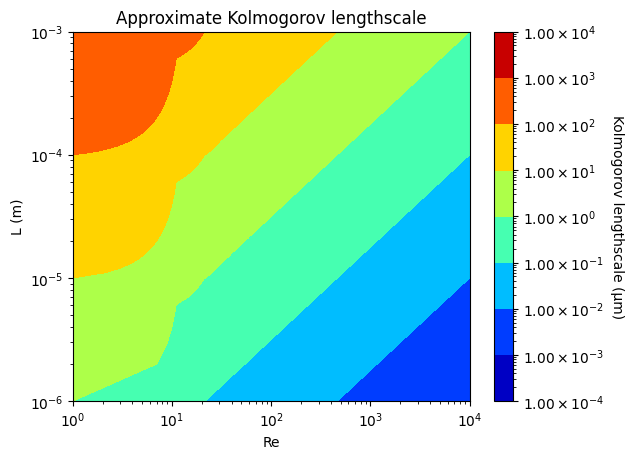

In [8]:
plot_kolm_lengthscale(Re_list, L_list, eta_array, Re_log_scale = True, L_log_scale = True, eta_log_scale = True, colormap = 'jet', nbr_of_countours = 100)

## Kolmogorv timescale approximate

In [88]:
def calculate_approx_kolm_timescale(Re_list, T_carac_list):
    ###Function that calulates Approximate Kolmogorov timescale for given range of T_carac and Re
    ##Input = Re_list, T_carac_list (in seconds)
    ##Output = array of t_eta, in seconds, ie Kolmogorov scale, approximate, for each pair of Re and T_carac values of the given range
    
    ## Create the data to plot
    #Need to reshape the array to Nx1 array in order to calulate transpose and matrix product
    
    Re_list_reshaped = np.reshape(Re_list, (np.size(Re_list), 1))
    T_carac_list_reshaped = np.reshape(T_carac_list, (np.size(T_carac_list), 1))

    #Calculate Kolmogorov timescale with t_eta =~ T_carac/(Re^0.5)
    Re_list_reshaped_raised_to_power = Re_list_reshaped**(-0.5)
    t_eta_array = T_carac_list_reshaped@Re_list_reshaped_raised_to_power.T #Values of Kolmogorov timescale with t_eta (Approximate) in seconds, see formula ref. in Utah University report turblt (add ref.)
    #t_eta_array = t_eta_array*1e6 #Conversion to micro seconds
    
    return t_eta_array

In [89]:
#T_carac_list = L_list/U_list

Kolmogorv timescale approximate plot depending on Re and caracteristic timescale T = L/U of system